In [1]:
import gym
import numpy as np
import math
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
class DQN(nn.Module):

    def __init__(self, inputs, outputs):
        super(DQN, self).__init__()

        self.fc1 = nn.Linear(inputs, 10)
        self.fc2 = nn.Linear(10, outputs)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [3]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = [] # Queue-like
        self.position = 0

    def push(self, experience):
        """Saves a experience."""
        if len(self.memory) < self.capacity:
            self.memory.append(None) # if we haven't reached full capacity, we append a new transition
        self.memory[self.position] = experience  
        self.position = (self.position + 1) % self.capacity # e.g if the capacity is 100, and our position is now 101, we don't append to
        # position 101 (impossible), but to position 1 (its remainder), overwriting old data

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size) 

    def __len__(self): 
        return len(self.memory)

### DQN algorithm

In [4]:
loss_log = []
# Action selection , if stop training == True, only exploitation
def select_action(state):
    q_value = policy_net(state)
    best_action = q_value.max(0)[1]
    # print('============in select_action============')
    # print('q_value', q_value)
    # print('best_action',best_action)
    while best_action.item() not in available_action:
        q_value[best_action.item()] = torch.cuda.FloatTensor([float('-inf')])
        best_action = q_value.max(0)[1]
        # print('q_value', q_value)
        # print('best_action',best_action)
    with torch.no_grad():
        return best_action

# Training 
def optimize_model(state, is_player):
    if len(memory) < BATCH_SIZE:
        print(f'Save experiences to memory. Current memory:{len(memory)}')
        return
    
    next_state, reward, done = memory.sample(BATCH_SIZE)[0]
    next_state = torch.cuda.FloatTensor(next_state).view(27).to(device)
    
    q_value = policy_net(state).gather(0, action)
    next_q_value = target_net(next_state).max(0)[0].detach()

    # Compute Q values
    expected_next_q_value = (next_q_value * GAMMA) + reward

    # Compute Huber loss
    loss = F.smooth_l1_loss(q_value, expected_next_q_value)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()
    loss_log.append(loss.cpu().detach())



In [5]:
import importlib
from collections import defaultdict

game_name = 'tictactoe'
game_module = importlib.import_module("games." + game_name)
env = game_module.Game()

state = env.reset()
available_action = env.legal_actions()
n_actions = len(available_action)

BATCH_SIZE = 5 # original = 128
GAMMA = 0.999 # original = 0.999
N_EPISODES = 10 # total episodes to be run
MEMORY_SIZE = 100000 # original = 10000
EPS_START = 0.9 # original = 0.9
EPS_END = 0.01 # original = 0.05
EPS_DECAY = 3000 # original = 200


policy_net = DQN(state.flatten().shape[0], len(available_action)).to(device)
target_net = DQN(state.flatten().shape[0], len(available_action)).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(MEMORY_SIZE)

player = 1

for episode in range(N_EPISODES):
    if episode % 10000 == 9999:
        print("episode: ", episode + 1)
    state = env.reset()
    state = torch.FloatTensor(state).view(27).to(device)

    is_done = False
    available_action = env.legal_actions()
    while not is_done:
        print("player:", env.to_play())
        print('available_action',available_action)

        action = select_action(state)
        print(action)
        available_action = list(set(available_action)-set([action.item()]))
        next_state, reward, is_done = env.step(action)
        next_state = torch.FloatTensor(next_state).view(27).to(device)
        optimize_model(state, True)
            
        env.render()
        
        if is_done:
            break

        memory.push((state, reward, is_done))
        state = next_state
    print('='*20)


print('Complete')

player: 1
available_action [0, 1, 2, 3, 4, 5, 6, 7, 8]
tensor(7, device='cuda:0')
Save experiences to memory. Current memory:0
   |   |   
---+---+---
   |   |   
---+---+---
   | O |   
player: -1
available_action [0, 1, 2, 3, 4, 5, 6, 8]
tensor(0, device='cuda:0')
Save experiences to memory. Current memory:1
 X |   |   
---+---+---
   |   |   
---+---+---
   | O |   
player: 1
available_action [1, 2, 3, 4, 5, 6, 8]
tensor(4, device='cuda:0')
Save experiences to memory. Current memory:2
 X |   |   
---+---+---
   | O |   
---+---+---
   | O |   
player: -1
available_action [1, 2, 3, 5, 6, 8]
tensor(3, device='cuda:0')
Save experiences to memory. Current memory:3
 X |   |   
---+---+---
 X | O |   
---+---+---
   | O |   
player: 1
available_action [1, 2, 5, 6, 8]
tensor(5, device='cuda:0')
Save experiences to memory. Current memory:4
 X |   |   
---+---+---
 X | O | O 
---+---+---
   | O |   
player: -1
available_action [8, 1, 2, 6]
tensor(8, device='cuda:0')
 X |   |   
---+---+---
 

In [6]:
print(loss_log)

[tensor(0.0647), tensor(0.0610), tensor(0.0028), tensor(0.5129), tensor(0.0021), tensor(0.0038), tensor(0.0087), tensor(0.0046), tensor(0.0660), tensor(0.0739), tensor(0.0094), tensor(0.0061), tensor(0.0543), tensor(0.0158), tensor(0.0792), tensor(0.0696), tensor(0.1036), tensor(0.0016), tensor(0.0002), tensor(0.0015), tensor(0.0278), tensor(0.0155), tensor(0.0425), tensor(0.0426), tensor(0.0434), tensor(0.0091), tensor(0.0357), tensor(0.0222), tensor(0.0097), tensor(0.0002), tensor(0.0021), tensor(0.0294), tensor(0.0002), tensor(0.0035), tensor(0.0047), tensor(0.0010), tensor(0.0136), tensor(0.0021), tensor(0.0532), tensor(0.0910), tensor(0.0264), tensor(0.0327), tensor(0.0021), tensor(0.0026), tensor(0.0037), tensor(0.0002), tensor(0.0584), tensor(0.0003), tensor(0.0308), tensor(0.0017), tensor(0.0022), tensor(0.0339), tensor(3.1908e-05), tensor(0.0359), tensor(0.0024), tensor(0.0406), tensor(0.0099), tensor(0.1726), tensor(0.0443), tensor(0.0013), tensor(0.0277), tensor(0.0100), ten

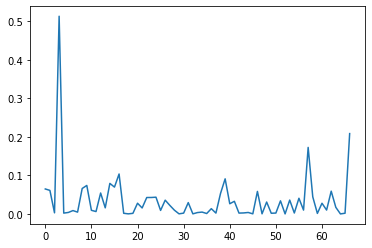

In [7]:
import matplotlib.pyplot as plt

plt.plot(loss_log)